In [3]:
from Almanac.Data import get_weather_data
from Almanac.Data import get_frost_dates
from Almanac.Data import binarize
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

%matplotlib inline

In [4]:
df = get_weather_data("Chicago, IL", "2015-01-01", "2021-12-31")
df_future = get_weather_data("Chicago, IL", "2022-01-01", "2022-12-31")

In [5]:
df.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2015-01-01,-4.3,-8.3,0.0,0.0,0.0,240.0,25.5,NaN,1019.8,NaN
2015-01-02,-1.5,-6.7,2.2,0.0,0.0,NaN,7.8,NaN,1025.3,NaN
2015-01-03,1.6,-0.6,2.8,15.0,0.0,NaN,8.5,NaN,1013.7,NaN
2015-01-04,-3.7,-15.0,2.2,4.6,51.0,305.0,20.2,NaN,NaN,NaN
2015-01-05,-15.6,-18.3,-12.2,3.8,102.0,NaN,17.5,NaN,NaN,NaN


In [6]:
df["tmin"].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2557 entries, 2015-01-01 to 2021-12-31
Freq: D
Series name: tmin
Non-Null Count  Dtype  
--------------  -----  
2557 non-null   float64
dtypes: float64(1)
memory usage: 40.0 KB


<Axes: xlabel='time'>

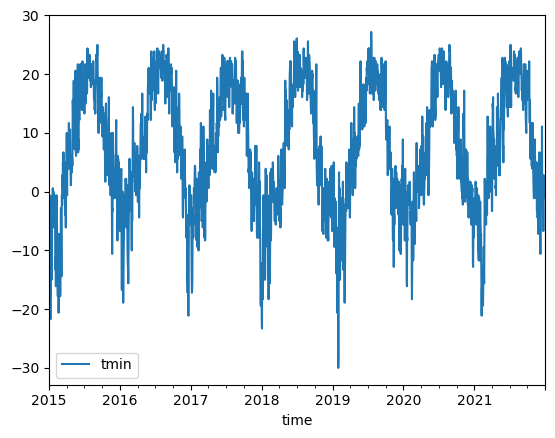

In [7]:
df.plot(y="tmin")

In [8]:
first, last = get_frost_dates(df)

In [9]:
f = pd.Series(first)
s = pd.Series(last)

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [11]:
decomp = seasonal_decompose(
    df["tmin"].resample("W").min().dropna(),
    model="add",
    extrapolate_trend="freq",
    period=52,
)

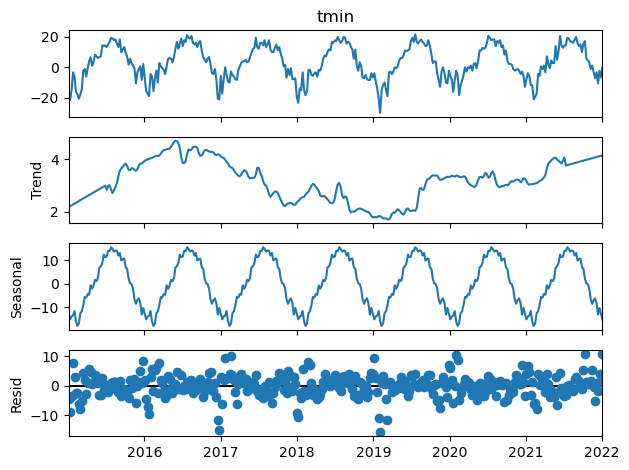

In [12]:
decomp.plot();

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [14]:
mod = SARIMAX(
    df["tmin"].resample("W").min(),
    order=(3, 0, 2),
    seasonal_order=(3, 0, 0, 52),
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False,
)

In [15]:
r = mod.fit()

In [14]:
def sarima_forecast(data, config, start=None, end=None):
    order, sorder, trend = config
    model = SARIMAX(
        data,
        order=order,
        seasonal_order=sorder,
        trend=trend,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )

    model_fit = model.fit(max_iter=100)

    if (start != None) & (end != None):
        prediction = model_fit.predict(start=start, end=end)
        print("Returning forecast")
        return prediction
    else:
        print("Returning fitted model")
        return model_fit

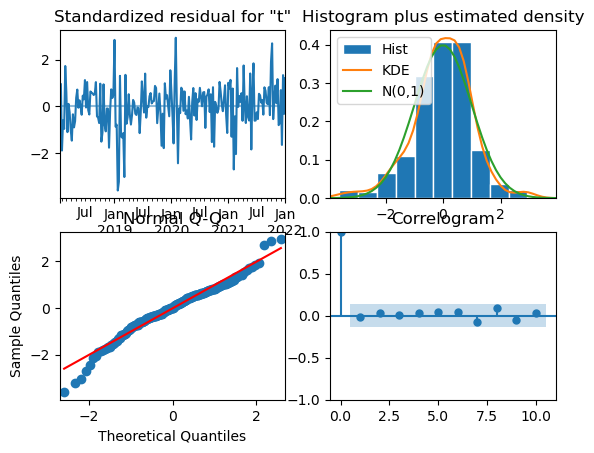

In [15]:
r.plot_diagnostics();

In [16]:
pred = r.get_prediction(start="2021-01-03", dynamic=False)

In [17]:
from sklearn.metrics import mean_squared_error

<Axes: xlabel='time'>

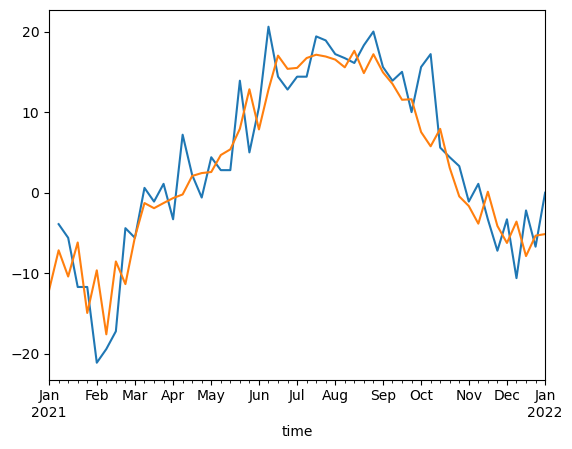

In [18]:
df["tmin"].resample("W").min().iloc[-52:].plot()
pred.predicted_mean.plot()

In [19]:
mean_squared_error(
    df["tmin"].resample("W").min()["2021-01-03":"2021-12-31"],
    pred.predicted_mean[0:52],
    squared=False,
)

4.459688256819098

In [20]:
type(pred)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

<Axes: >

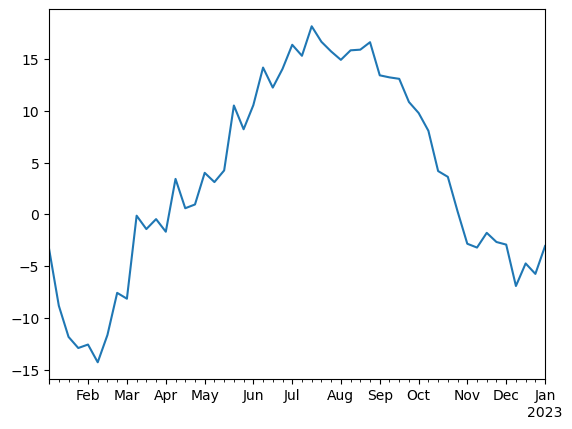

In [21]:
r.forecast("2022-12-31").plot()

<Axes: xlabel='time'>

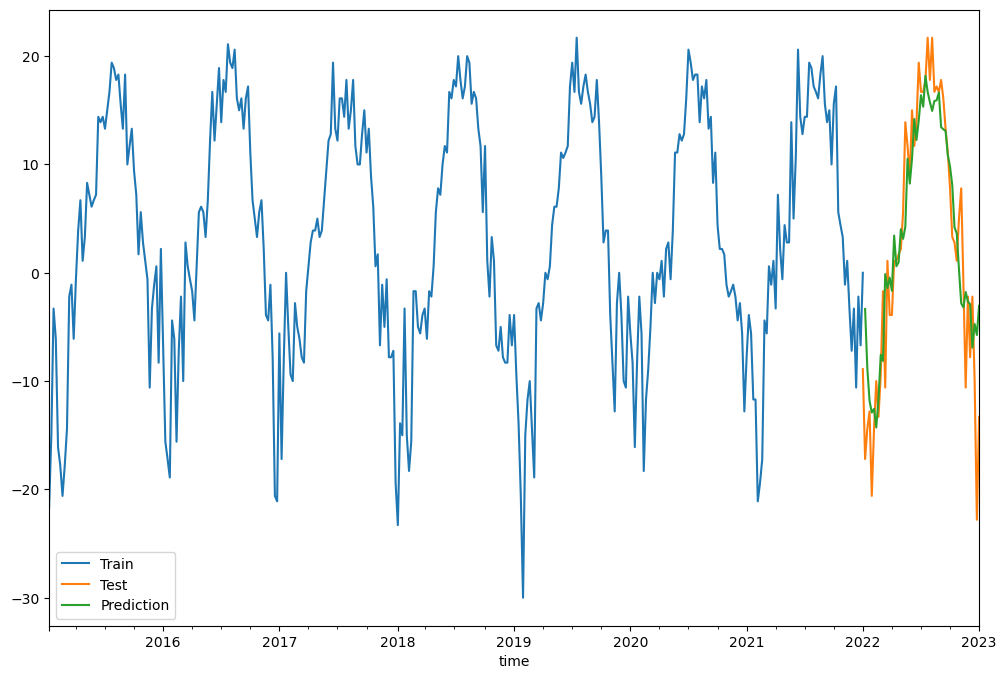

In [22]:
fig = plt.figure(figsize=(12, 8))
df["tmin"].resample("W").min().iloc[-365:].plot(label="Train", legend=True)
df_future["tmin"].resample("W").min().plot(label="Test", legend=True)
r.predict(start="2022-01-03", end="2022-12-31").plot(
    label="Prediction", legend=True
)

In [23]:
r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                tmin   No. Observations:                  366
Model:             SARIMAX(3, 0, 2)x(3, 0, [], 52)   Log Likelihood                -592.779
Date:                             Fri, 15 Dec 2023   AIC                           1205.559
Time:                                     15:17:56   BIC                           1238.886
Sample:                                 01-04-2015   HQIC                          1219.036
                                      - 01-02-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4400      0.498      0.884      0.377      -0.535       1.415
ar.L1          0.6565      0.309      2.123      0.034       0.050       1.263
ar.L2         -0.8163      0.279     -2.926      0.003      -1.363      -0.270
ar.L3          0.2751      0.126      2.190      0.029       0.029       0.521
ma.L1         -0.1805      0.317     -0.570      0.569      -0.801       0.440
ma.L2          0.6128      0.279      2.198      0.028       0.066       1.159
ar.S.L52       0.3627      0.065      5.560      0.000       0.235       0.491
ar.S.L104      0.2483      0.062      3.987      0.000       0.126       0.370
ar.S.L156      0.2869      0.057      5.063      0.000       0.176       0.398
sigma2        17.9828      1.694     10.616      0.000      14.663      21.303
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                22.87
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.43
Prob(H) (two-sided):                  0.27   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
mean_squared_error(
    df_future["tmin"].resample("W").min()[1:53],
    r.predict(start="2022-01-03", end="2022-12-31"),
    squared=False,
)

5.340004122676212

In [25]:
df_future["tmin"].resample("W").mean()

time
2022-01-02    -5.000000
2022-01-09   -11.328571
2022-01-16    -6.971429
2022-01-23    -9.142857
2022-01-30   -13.114286
2022-02-06    -7.042857
2022-02-13    -5.314286
2022-02-20    -7.057143
2022-02-27    -4.757143
2022-03-06     1.185714
2022-03-13    -4.371429
2022-03-20     4.200000
2022-03-27     3.728571
2022-04-03     0.957143
2022-04-10     3.885714
2022-04-17     4.542857
2022-04-24     8.571429
2022-05-01     6.914286
2022-05-08     7.857143
2022-05-15    20.157143
2022-05-22    13.414286
2022-05-29    13.242857
2022-06-05    18.185714
2022-06-12    14.542857
2022-06-19    20.328571
2022-06-26    21.014286
2022-07-03    19.685714
2022-07-10    21.028571
2022-07-17    20.971429
2022-07-24    22.714286
2022-07-31    20.014286
2022-08-07    23.900000
2022-08-14    19.300000
2022-08-21    19.442857
2022-08-28    19.185714
2022-09-04    20.642857
2022-09-11    18.885714
2022-09-18    17.771429
2022-09-25    15.314286
2022-10-02    10.385714
2022-10-09     8.257143
2022-10-16 

In [26]:
predicted = sarima_forecast(
    df["tmin"].resample("W").min(), ((3, 0, 0), (0, 1, 1, 52), ("c"))
)

Returning fitted model


In [27]:
predicted.aic

1509.4637794474481

In [28]:
def score_model(data, config):
    train = data.resample("W").min()[0:-9]
    test = data.resample("W").min()[-9:]
    pred = sarima_forecast(
        train["tmin"], config, start=test.index[0], end=test.index[-1]
    )
    rmse = mean_squared_error(test["tmin"], pred, squared=False)
    key = str(config)
    print(" > Model[%s] %.3f" % (key, rmse))
    return (key, rmse)

In [29]:
df["tmin"].resample("W").min()[-9:]

time
2021-11-07    -1.1
2021-11-14     1.1
2021-11-21    -3.3
2021-11-28    -7.2
2021-12-05    -3.3
2021-12-12   -10.6
2021-12-19    -2.2
2021-12-26    -6.7
2022-01-02     0.0
Freq: W-SUN, Name: tmin, dtype: float64

In [30]:
# score_model(df,((3, 0, 0), (0, 1, 1, 52), ("c")))

In [31]:
# from joblib import Parallel, delayed, cpu_count

In [32]:
# executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')

In [33]:
# cfg_list = []

# for p in range(4):
#     for d in range(2):
#         for q in range(4):
#             for P in range(4):
#                 for D in range(2):
#                     for Q in range(4):
#                         cfg_list.append(((p,d,q),(P,D,Q,52),"c"))

In [34]:
# len(cfg_list)

In [35]:
def grid_search(data, cfg_list, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count())
        tasks = (delayed(score_model)(data, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, cfg) for cfg in cfg_list]
        # remove empty results
        scores = [r for r in scores if r[1] != None]
        # sort configs by error, asc
        scores.sort(key=lambda tup: tup[1])
    return scores

In [36]:
# s = grid_search(df,cfg_list,parallel=True)

In [37]:
# con = [x[0] for x in s]
# err = [x[1] for x in s]

In [38]:
# err.index(min(err))

In [39]:
# con[856]

In [40]:
# err[856]

In [41]:
years = list(range(1990, 2021, 1))
pred_dict = {}

location = "Chicago, IL"
start = "1985-01-01"

config = ((3, 0, 2), (3, 0, 0, 52), "c")

In [42]:
data = get_weather_data(location, start, str(1990) + "-12-31")
data["tmin"].resample("W").min().index[0]

Timestamp('1985-01-06 00:00:00')

In [43]:
data[data.index.year == 1990]

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
1990-01-01,-2.3,-3.9,-1.7,0.0,25.0,277.0,25.3,48.2,1021.2,0.0
1990-01-02,0.0,-3.9,4.4,0.0,25.0,204.0,26.6,50.0,1021.5,553.0
1990-01-03,3.4,0.6,7.2,4.6,0.0,205.0,27.1,51.8,1015.5,292.0
1990-01-04,2.7,-3.3,7.8,7.9,0.0,262.0,24.5,46.4,1012.7,113.0
1990-01-05,-1.7,-5.6,2.8,0.0,0.0,NaN,13.0,33.5,1021.1,556.0
...,...,...,...,...,...,...,...,...,...,...
1990-12-27,-7.8,-11.7,-3.9,0.8,25.0,146.0,16.9,33.5,1032.4,411.0
1990-12-28,-1.3,-4.4,4.4,7.6,0.0,176.0,20.2,44.3,1020.0,0.0
1990-12-29,4.1,-2.8,6.1,15.5,0.0,275.0,14.1,33.5,1012.6,0.0


In [ ]:
for year in years:
    print(year)
    data = get_weather_data(location, start, str(year) + "-12-31")
    dw = data["tmin"].resample("W").min()
    try:
        pred_dict[year + 1] = sarima_forecast(
            dw,
            config,
            dw[dw.index.year == year + 1].index[0],
            str(year + 1) + "-12-31",
        )
    except IndexError:
        pred_dict[year + 1] = sarima_forecast(
            dw, config, str(year + 1) + "-01-01", str(year + 1) + "-12-31"
        )

1990


Returning forecast
1991


Returning forecast
1992
Returning forecast
1993
Returning forecast
1994
Returning forecast
1995
Returning forecast
1996
Returning forecast
1997
Returning forecast
1998
Returning forecast
1999
Returning forecast
2000
Returning forecast
2001
Returning forecast
2002
Returning forecast
2003
Returning forecast
2004


Returning forecast
2005
Returning forecast
2006
Returning forecast
2007
Returning forecast
2008
Returning forecast
2009
Returning forecast
2010


In [ ]:
pred_dict[2000]

In [ ]:
dw[dw.index.year == 1990].index[0]

In [ ]:
get_frost_dates(
    pd.DataFrame(pred_dict[2000][pred_dict[2000].index.year == 2001]).rename(
        columns={"predicted_mean": "tmin"}
    )
)

In [ ]:
pd.DataFrame(pred_dict[2000][pred_dict[2000].index.year == 2000]).rename(
    columns={"predicted_mean": "tmin"}
)

In [ ]:
first = []
last = []

In [ ]:
for year in pred_dict.keys():
    f, l = get_frost_dates(
        pd.DataFrame(
            pred_dict[year][pred_dict[year].index.year == (year + 1)]
        ).rename(columns={"predicted_mean": "tmin"})
    )
    first.append(f)
    last.append(l)

In [ ]:
get_frost_dates(
    pd.DataFrame(pred_dict[1993][pred_dict[1993].index.year == (1993)]).rename(
        columns={"predicted_mean": "tmin"}
    )
)

In [ ]:
pred_dict[1993]

In [ ]:
last

In [ ]:
df_dict = {}

In [ ]:
for year in pred_dict.keys():
    df_dict[year] = get_weather_data(
        location, start=f"{year}-01-01", end=f"{year}-12-31"
    )

In [ ]:
first_act = []
last_act = []

In [ ]:
for year in df_dict.keys():
    f, l = get_frost_dates(df_dict[year])
    first_act.append(f)
    last_act.append(l)

In [ ]:
first_act

In [ ]:
first

In [ ]:
len(first_act)

In [ ]:
(first[1][0] - first_act[1][0]).days

In [ ]:
first

In [ ]:
first_diffs = []
last_diffs = []

In [ ]:
for i, data in enumerate(first):
    first_diffs.append((first[i][0] - first_act[i][0]).days)
    last_diffs.append((last[i][0] - last_act[i][0]).days)

In [ ]:
fig2 = plt.figure(figsize=(12, 8))
plt.scatter(x=range(1990, 2021), y=[x for x in last_diffs])
fig2.get_axes()[0].set_title("Last Frost (Prediction - Observed)")
fig2.get_axes()[0].set_ylabel("days")

In [ ]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(x=range(1990, 2021), y=[x for x in first_diffs])
fig.get_axes()[0].set_title("First Frost (Prediction - Observed)")
fig.get_axes()[0].set_ylabel("days")

In [ ]:
f = pd.Series(first_diffs)
l = pd.Series(last_diffs)

In [ ]:
f.abs().mean()

In [ ]:
l.abs().mean()

In [ ]:
f.abs().std()

In [ ]:
l.abs().std()

In [ ]:
df = get_weather_data("Chicago, IL", "2015-01-01", "2021-12-31")
df_future = get_weather_data("Chicago, IL", "2022-01-01", "2022-12-31")

In [ ]:
pred = sarima_forecast(
    df["tmin"].resample("W").min(), config, "2022-01-02", "2022-12-31"
)

In [ ]:
pred

In [ ]:
act = df_future["tmin"].resample("W").min()

In [ ]:
act

In [ ]:
pred - act

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor(n_estimators=600)

In [ ]:
from sklearn.preprocessing import FunctionTransformer

In [ ]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [ ]:
df_future["day_sin"] = sin_transformer(365).fit_transform(
    df_future.index.day_of_year
)
df_future["day_cos"] = cos_transformer(365).fit_transform(
    df_future.index.day_of_year
)

In [ ]:
df_future

In [ ]:
act.index

In [ ]:
# pred2 = sarima_forecast(df["tmin"],((3,0,2),(3,0,0,365),"c"),"2022-01-01","2022-12-31")

In [ ]:
act_df = pd.DataFrame(
    {
        "act": act,
        "day_sin": sin_transformer(365).fit_transform(act.index.day_of_year),
        "day_cos": cos_transformer(365).fit_transform(act.index.day_of_year),
    }
)

In [ ]:
act_df

In [ ]:
act_df["diff"] = act - pred

In [ ]:
act_df

In [ ]:
act_df[act_df.index[0] : act_df.index[35]]

In [ ]:
rfr.fit(
    act_df[act_df.index[0] : act_df.index[35]][["day_sin", "day_cos"]],
    act_df[act_df.index[0] : act_df.index[35]]["diff"],
)

In [ ]:
pred_diff = rfr.predict(act_df[act_df.index[35] :][["day_sin", "day_cos"]])

In [ ]:
pred_diff

In [ ]:
pred[pred.index[35] :] + act_df[act_df.index[35] :]["diff"] - pred_diff

In [ ]:
act_df[act_df.index[35] :]["act"]